## Ensemble Hybrid deep learning model for Belt sensor Dataset

In [73]:
### Random Seed
from numpy.random import seed
seed(1)

###   Models

In [74]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import csv

In [22]:
# Read dataset
#df1 = pd.read_csv('Belt_sensor_1stbatch.csv')
#df2 = pd.read_csv('belt_sensor_2ndbatch.csv')
#df=pd.concat([df1,df2],axis=0)
df.to_csv('belt_sensor_all.csv')

In [75]:
df = pd.read_csv('belt_sensor_all.csv')
print(df.shape)
df.head(2)

(108170, 22)


,Unnamed: 0,Pid,timestamp,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,...,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label
0,0,P1_BS,3.00,-84.23,-994.63,8.06,-0.37,-2.62,1.65,311.28,...,2.08,-3.23,-4.33,-68.12,-970.46,150.15,1.83,0.24,0.61,Downstairs
1,1,P1_BS,3.01,-86.43,-1004.15,16.85,-0.18,-3.17,0.85,301.76,...,6.77,3.05,-3.78,-73.24,-978.52,140.62,0.55,-0.24,0.31,Downstairs


In [76]:
df.groupby('Pid').size()

Pid
P1_BS            12278
P2_BS            13016
P3_BS            13016
P4_BS            12946
P5_BS            13016
p10_all_BS123     8825
p11_all_BS123     8598
p6_all_BS123      8825
p7_all_BS123      8825
p8_all_BS123      8825
dtype: int64

In [77]:
### Low Pass filter 
from scipy import signal
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [78]:
#low pass filter
lowpass_filtred=[]
dfm=df[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
for column in dfm.columns:# iterate over each column in raw_df
    cutoff_frequency = 15.0
    sample_rate=100
    t_signal=np.array(dfm[column]) #copie the signal values in 1D numpy array
    y = butter_lowpass_filter(t_signal,cutoff_frequency,sample_rate/2) 
    lowpass_filtred.append(y)
lowpass=pd.DataFrame(lowpass_filtred)
lowpass=lowpass.T
lowpass.columns=['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']
df1=df[['Pid','timestamp']]
df_filtred=pd.concat([df1,lowpass],axis=1)
df_filtred['Label']=df['Label']

In [79]:
df_filtred['Label'].value_counts()

Label
Upstairs      29345
Downstairs    25030
Walking       19440
Standing      12180
Sitting       11265
Laying        10910
Name: count, dtype: int64

In [80]:
from imblearn.over_sampling import SMOTE

In [81]:
# split data into input and output elements
X = df_filtred[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy',
       'S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
y = df_filtred[['Label']]

oversample = SMOTE()
Xo, yo = oversample.fit_resample(X, y)

df_Smoted=pd.concat([Xo,yo],axis=1)
print(df_Smoted.shape)
df_Smoted.head(2)

(176070, 19)


,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,S2_Ay,S2_Az,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label
0,-84.222490,-994.627346,8.055153,-0.370396,-2.620791,1.649596,311.291489,-1061.332673,81.294603,2.077435,-3.234044,-4.329407,-68.121248,-970.461276,150.138268,1.829730,0.240081,0.610366,Downstairs
1,-88.069874,-998.773910,11.651440,-0.282880,-3.161370,0.810362,301.127326,-1027.592784,86.576920,6.452058,2.962058,-3.769370,-70.387323,-977.643665,146.687971,0.477777,-0.317638,0.282808,Downstairs


: 

### Label encoding

In [32]:
df_Smoted['Label_id']=df_Smoted['Label']
dff=df_Smoted.replace({'Label_id': {'Downstairs':0,'Walking':1,'Upstairs':2,
                        'Sitting':3,'Laying':4,'Standing':5}})
dff.head(2)

,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,S2_Ay,S2_Az,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label,Label_id
0,-84.222490,-994.627346,8.055153,-0.370396,-2.620791,1.649596,311.291489,-1061.332673,81.294603,2.077435,-3.234044,-4.329407,-68.121248,-970.461276,150.138268,1.829730,0.240081,0.610366,Downstairs,0
1,-88.069874,-998.773910,11.651440,-0.282880,-3.161370,0.810362,301.127326,-1027.592784,86.576920,6.452058,2.962058,-3.769370,-70.387323,-977.643665,146.687971,0.477777,-0.317638,0.282808,Downstairs,0


In [33]:
#Label encoding
#df_filtred['Label_id']=df_filtred['Label']
#dff=df_filtred.replace({'Label_id': {'Downstairs':0,'Walking':1,'Upstairs':2,
                        #'Sitting':3,'Laying':4,'Standing':5}})
### Normalize/Standardize data
from sklearn.preprocessing import StandardScaler, LabelEncoder
X = dff[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
y = dff['Label_id']
scaler = StandardScaler()
dx = scaler.fit_transform(X)

df_scaled = pd.DataFrame(data = dx, columns = X.columns)
df_scaled['Label_id'] = y.values

print(df_scaled.shape)
df_scaled.tail(2)

(176070, 19)


,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,S2_Ay,S2_Az,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label_id
176068,-0.536703,-0.201800,0.750810,-0.049962,0.337723,-0.442442,1.399594,-0.343111,-0.674110,-1.999509,-0.876199,1.831822,-0.282841,0.632618,1.108624,0.136759,-0.321555,1.28865,1
176069,-0.380689,0.473902,-0.034096,2.680881,0.106790,-1.200877,-0.054480,-0.154568,-0.285668,-1.169382,-0.124162,-1.088952,0.499170,-0.602965,0.609451,-0.082274,-0.707267,-0.33340,1


In [40]:
## Segmentation (window Preparation)
import scipy.stats as stats
Fs = 100
segment_size = 500 # fs*3 # window size=n_time steps=frame size
step_size = 50  #  Fs/2 # step size is related to window overlap
n_features = 18
def get_segments(df, segment_size, step_size):

    segments = []
    labels = []
    
    for i in range(0, len(df) - segment_size - 1, step_size):
        S1Ax = df_scaled['S1_Ax'].values[i: i + segment_size]
        S1Ay = df_scaled['S1_Ay'].values[i: i + segment_size]
        S1Az = df_scaled['S1_Az'].values[i: i + segment_size]
        S1Gx = df_scaled['S1_Gx'].values[i: i + segment_size]
        S1Gy = df_scaled['S1_Gy'].values[i: i + segment_size]
        S1Gz = df_scaled['S1_Gz'].values[i: i + segment_size]
        
        S2Ax = df_scaled['S2_Ax'].values[i: i + segment_size]
        S2Ay = df_scaled['S2_Ay'].values[i: i + segment_size]
        S2Az = df_scaled['S2_Az'].values[i: i + segment_size]
        S2Gx = df_scaled['S2_Gx'].values[i: i + segment_size]
        S2Gy = df_scaled['S2_Gy'].values[i: i + segment_size]
        S2Gz = df_scaled['S2_Gz'].values[i: i + segment_size]
        
        
        S3Ax = df_scaled['S3_Ax'].values[i: i + segment_size]
        S3Ay = df_scaled['S3_Ay'].values[i: i + segment_size]
        S3Az = df_scaled['S3_Az'].values[i: i + segment_size]
        S3Gx = df_scaled['S3_Gx'].values[i: i + segment_size]
        S3Gy = df_scaled['S3_Gy'].values[i: i + segment_size]
        S3Gz = df_scaled['S3_Gz'].values[i: i + segment_size]
        
          # Retrieve the most often used label in this segment
        # label = stats.mode(df_scaled['Label_id'][i: i + segment_size])[0][0] ## [0][0] shows the current sequence
        label = np.unique(df_scaled['Label_id'][i: i + segment_size])[0]

        #We used the dstack() to ensure that each array is stacked in such a way that
        #the features are separated in the third dimension, as we would prefer.
        segments.append(np.dstack([S1Ax, S1Ay, S1Az,S1Gx,S1Gy,S1Gz,S2Ax,S2Ay,S2Az, S2Gx,S2Gy,S2Gz,S3Ax,S3Ay,S3Az,S3Gx,S3Gy,S3Gz]))
        labels.append(label)

    # Bring the segments into a better shape
    segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
        
    return segments, labels


In [41]:
X, y = get_segments(df_scaled, segment_size, step_size)

In [42]:
X.shape,y.shape, y.shape[0]

((3512, 500, 18), (3512, 6), 3512)

### CNN-LSTM
The CNN-LSTM architecture involves using Convolutional Neural Network (CNN) layers for
feature extraction on input data combined with LSTMs to support sequence prediction. The CNN-LSTM model will read subsequences of the main sequence in as blocks, extract features from each block, then allow the LSTM to interpret the features extracted from each block. One approach to implementing this model is to split each window of 128 time steps into
subsequences for the CNN model to process. For example, the 128 time steps in each window can be split into four subsequences of 32 time steps

In [43]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 10, 50
df_X = X.reshape((X.shape[0], n_steps, n_length, n_features))
n_outputs = y.shape[1] #n_outputs= 6

In [44]:
df_X.shape,np.shape(y)

((3512, 10, 50, 18), (3512, 6))

We can then define a CNN model that expects to read in sequences with a length of 32 time
steps and three features. The entire CNN model can be wrapped in a TimeDistributed layer
to allow the same CNN model to read in each of the four subsequences in the window. The
extracted features are then flattened and provided to the LSTM model to read, extracting its
own features before a final mapping to an activity is made.

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers import Conv1D  # Updated import
from keras.layers import MaxPooling1D  # Updated import

In [51]:
#from sklearn.model_selection import GridSearchCV
import keras
# from keras.wrappers.scikit_learn import KerasClassifier
# # from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier  # Updated import
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

In [20]:
# split training set into training and validation set
#X_train, X_test, y_train, y_test = train_test_split(df_X,y,test_size=0.20,random_state=7)

In [52]:
# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(df_X, y,test_size=0.20, random_state=42)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.20,random_state=42)

In [53]:
X_train.shape,y_train.shape, X_valid.shape, y_valid.shape

((2247, 10, 50, 18), (2247, 6), (562, 10, 50, 18), (562, 6))

In [54]:
def create_model(optimizer= 'rmsprop' , init= 'glorot_uniform' ):
    # create model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [55]:
### Initialize Model
model_cnn_lstm=create_model()

In [56]:
history = model_cnn_lstm.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=32)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
71/71 [==============================] - ETA: 0s - loss: 1.3097 - accuracy: 0.4562WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000214EBD5A020> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set 

### Plot learning History

In [58]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

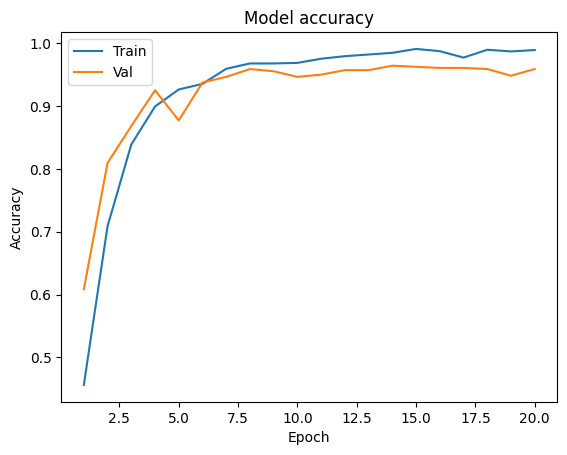

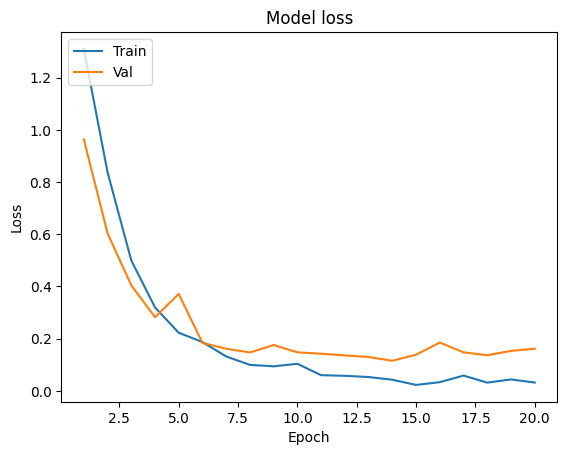

In [59]:
plot_learningCurve(history, 20)

## Save Model

In [60]:
model_cnn_lstm.save('cnn_lstm_all.h5')

C:\Users\Hadsaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  `tf.saved_model.SaveOptions` object that specifies SavedModel


In [61]:
np.set_printoptions(suppress=True) #suppress scientific notation when printing :numpy 

In [62]:
# Make Predictions on test 
y_preds_test = model_cnn_lstm.predict(X_test) #class Prediction 

y_preds_test[:3], #y_probs_test[:5]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
22/22 [==============================] - 2s 22ms/step


(array([[0.07877905, 0.00060156, 0.00003349, 0.00055421, 0.01056206,
         0.90946954],
        [0.00000148, 0.00000071, 0.00235733, 0.9969798 , 0.00065264,
         0.000008  ],
        [0.00000822, 0.00000009, 0.00000048, 0.00003376, 0.99993026,
         0.00002712]], dtype=float32),)

In [63]:
y_test[:5,]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [64]:
y_pred_test=np.argmax(y_preds_test,axis=1) 
y_true_test=np.argmax(y_test,axis=1) 

y_true_test.shape, y_test.shape

((703,), (703, 6))

###  Evaluate Model

In [65]:
### Evaluate Model using accuracy 
from sklearn.metrics import accuracy_score,classification_report
print("Test  acc : {}".format(accuracy_score(y_true_test, y_pred_test)))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_true_test, y_pred_test))

Test  acc : 0.9516358463726885

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       146
           1       0.97      0.89      0.93       130
           2       0.88      0.98      0.93       116
           3       0.97      0.95      0.96       116
           4       0.97      0.98      0.97       116
           5       0.94      0.96      0.95        79

    accuracy                           0.95       703
   macro avg       0.95      0.95      0.95       703
weighted avg       0.95      0.95      0.95       703



In [66]:
y_pred_test = model_cnn_lstm.predict(X_test) #class Prediction 

y_pred_test=np.argmax(y_pred_test,axis=1) 
y_true_test=np.argmax(y_test,axis=1) 

y_true_test.shape, y_pred_test.shape

22/22 [==============================] - 1s 28ms/step


((703,), (703,))

In [67]:
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true_test,y_pred_test)
print(cm)
print(acc(y_true_test,y_pred_test))
print(classification_report(y_true_test,y_pred_test))

[[139   3   0   0   0   4]
 [  4 116  10   0   0   0]
 [  0   0 114   2   0   0]
 [  0   0   5 110   1   0]
 [  0   0   0   1 114   1]
 [  0   0   0   0   3  76]]
0.9516358463726885
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       146
           1       0.97      0.89      0.93       130
           2       0.88      0.98      0.93       116
           3       0.97      0.95      0.96       116
           4       0.97      0.98      0.97       116
           5       0.94      0.96      0.95        79

    accuracy                           0.95       703
   macro avg       0.95      0.95      0.95       703
weighted avg       0.95      0.95      0.95       703



In [68]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))

In [69]:
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

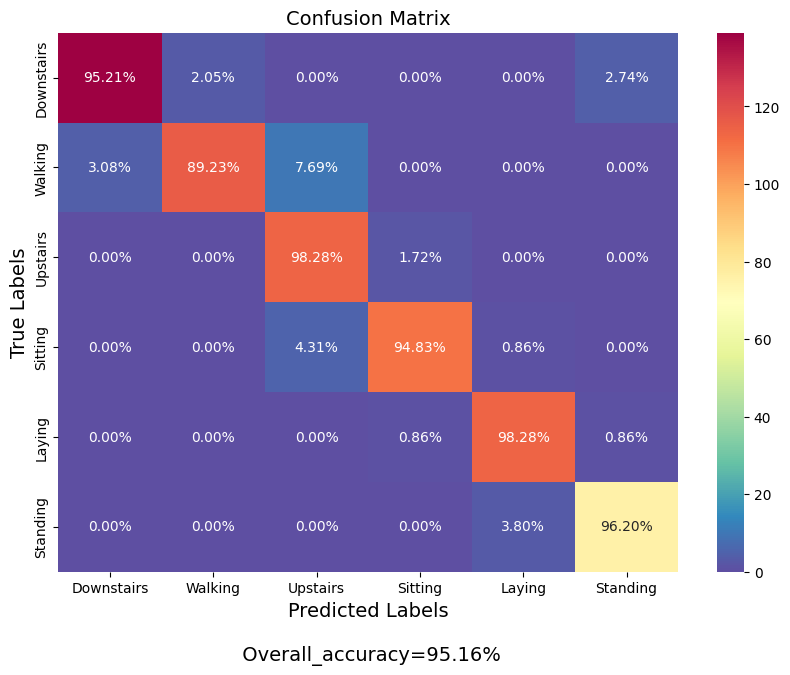

In [70]:
fig = plt.figure(figsize=(10,7))
ax=fig.add_subplot(111)
#sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
sns.heatmap(cm, annot=labels,fmt="",cmap='Spectral_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format((acc(y_true_test,y_pred_test))),size=14)
ax.set_ylabel("True Labels",size=14)
ax.set_title("Confusion Matrix",size=14)
ax.xaxis.set_ticklabels(['Downstairs','Walking','Upstairs','Sitting','Laying','Standing'])
ax.yaxis.set_ticklabels(['Downstairs','Walking','Upstairs','Sitting','Laying','Standing'])
plt.savefig('ConfusionMatrix_smart belt',dpi=1200, bbox_inches='tight')

In [71]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')

(0.9513939075856784, 0.9533634844553687, 0.9515557555177939, None)

In [72]:
from sklearn.metrics import precision_recall_fscore_support
p_r_f=precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')
prf=list(p_r_f)
pdf_2 = prf[:-1]
np.round(pdf_2,4)

array([0.9514, 0.9534, 0.9516])